# Testing basic ML algorithms in 2d 


Test of Logistic regression (LR) and of decision tree (DT) on a classification task with two variables, and a well defined separation line on the 2-d plane.   

### Performance verification :
    
* Look at evolution of loss as a function of the epoch for training and validation samples (only for LR)
* Plot distribution of output probability for signal and background
* Plot ROC
* For relevant variables compare distribution for events with probability<0.5 and events with probability<0.5
* Write out the optimised weights to nderstand the relative importance of variables (LR)
* Draw the final tree (DT)

In [47]:
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd

# Generate pattern in 2-d space

Divide a 2-d space in two regions based on a function of the two variables, 
and populate the two regions with randomly distributed points 

In [48]:
# define how many events you want
n=10000
# generate random inputs in [-0.5, 0.5]
X1 = np.random.random(n)-0.5
X2 = np.random.random(n)-0.5
# Define partition of space as a boolean function of the two variables
Y = X1*0.2+X2*0.3<0
# Y=((X1<0) & (X2<0)) | ((X1>0.25) & (X2>0.25))
#Y=((X1<-0.33) & (X2<0)) | ((X1>0.28) & (X2>0.40))
#Y=X1*X1*0.3-X2*0.2>0
#Y=X1*X1*0.3-X2*0.2>0
# stacking requires vectors to be defined as 2-d vector with
# second dimension=1
X1 = X1.reshape(n, 1)
X2 = X2.reshape(n, 1)
Y = Y.reshape(n, 1)
# print(X1)
# print(X2)
# print(Y)
data= np.hstack((X1, X2, Y))
# print(data)
df = pd.DataFrame(data,columns=['x1', 'x2','SIG'])

Visualise generated patterns in 2-d parameter space

In [49]:
def plot_scat(df, sel1, sel2, var1, var2, blx, bhx, bly, bhy):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  fig= plt.figure(figsize=(14,5))
  plt.subplot(1, 2,1)
  plt.xlim([blx,bhx])
  plt.ylim([bly,bhy])
  plt.plot(df_nopass[var1], df_nopass[var2], 'bo', alpha=0.4, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.subplot(1, 2,2)
  plt.xlim([blx,bhx])
  plt.ylim([blx,bhx])
  plt.plot(df_pass[var1], df_pass[var2], 'ro', alpha=0.4, label=sel1)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.show()

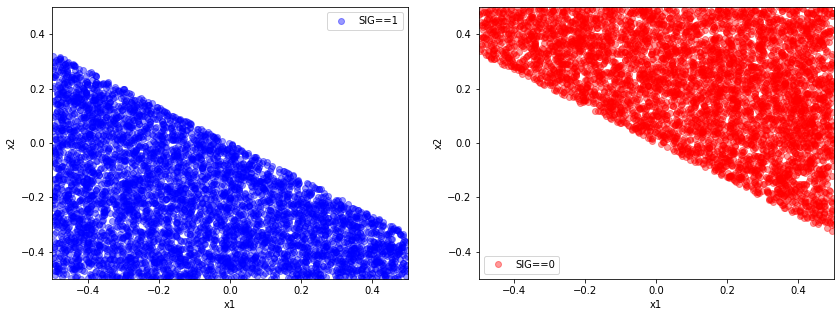

In [50]:
# now plot the covered area for the two 

sel1='SIG==0'
sel2='SIG==1'
plot_scat(df, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)

## Split train test and validation with sklearn

In [51]:
from sklearn.model_selection import train_test_split
#Define vectors for input to ML
# Use 'SIG' column as definition of target
y = df['SIG']
# define dataframe out of all columns except the "SIG" one
X = df[[col for col in df.columns if col!="SIG"]]
col_fin=X.columns
X_tv, X_test, y_tv, y_test = train_test_split(X, y,
                                   test_size=.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv,
                                   test_size=.10, random_state=0)


# Logistic regression

Implement in Keras and run

In [52]:
import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
#from keras.utils import plot_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import warnings

varnum=X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=varnum, activation='sigmoid'))
model.summary()

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, 
                  validation_data=(X_val,y_val), 
                  batch_size=100, epochs=100)

2.12.0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 1s 3ms/step - loss: 0.7755 - accuracy: 0.1670 - val_loss: 0.7669 - val_accuracy: 0.1800
Epoch 2/100
68/68 [==============================] - 0s 1ms/step - loss: 0.7638 - accuracy: 0.1810 - val_loss: 0.7555 - val_accuracy: 0.1933
Epoch 3/100
68/68 [==============================] - 0s 1ms/step - loss: 0.7524 - accuracy: 0.1994 - val_loss: 0.7444 - val_accuracy: 0.2120
Epoch 4/100
68/68 [==============================] - 0s 2ms/step - loss: 0.7414 - accuracy: 0.2224 - val_loss: 0.7336 - val_accuracy: 0.2413
Epoch 5/100
68/68

Epoch 55/100
68/68 [==============================] - 0s 1ms/step - loss: 0.4356 - accuracy: 0.9733 - val_loss: 0.4362 - val_accuracy: 0.9680
Epoch 56/100
68/68 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.9732 - val_loss: 0.4332 - val_accuracy: 0.9680
Epoch 57/100
68/68 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.9724 - val_loss: 0.4303 - val_accuracy: 0.9653
Epoch 58/100
68/68 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.9727 - val_loss: 0.4274 - val_accuracy: 0.9653
Epoch 59/100
68/68 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.9723 - val_loss: 0.4247 - val_accuracy: 0.9640
Epoch 60/100
68/68 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.9714 - val_loss: 0.4219 - val_accuracy: 0.9640
Epoch 61/100
68/68 [==============================] - 0s 2ms/step - loss: 0.4182 - accuracy: 0.9711 - val_loss: 0.4192 - val_accuracy: 0.9640
Epoch 

## Run prediction

In [53]:
Ypredr=model.predict(X_test)

79/79 [==============================] - 0s 1ms/step


## Create dataframe with labels and probabilities 

In [54]:
df_test_acc_r=X_test.copy()
df_test_acc_r['SIG']=y_test
df_test_acc_r['PROB']=Ypredr

# Look at the classification performance

## Plot history of losses along epochs for Keras

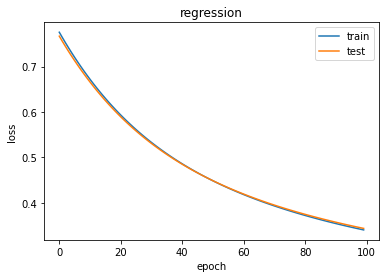

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('regression')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.


nsig  1296
nbkg  1204


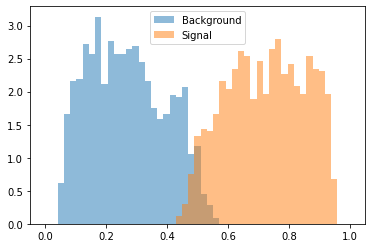

In [56]:
# split according to the label
df_test_acc_r_bkg = df_test_acc_r.query('SIG==0')
df_test_acc_r_sig = df_test_acc_r.query('SIG==1')
print('nsig ',df_test_acc_r_sig.shape[0])
print('nbkg ',df_test_acc_r_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_r_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_r_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC
In order to perform our the final selection we put a lower limit on the value of the probability and we count the fraction of events above this limit for both signal and backround, i.e for each value of PROB we have two values: The 'true positive rate (TPR)' (efficiency of signal selection in HEP language), and 'false positive rate (FPR)' (efficency for selecting background). If we TPR versus FPR the other as a function of PROB we obtain a curve called the Receive Operating Characteristic (ROC) curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Methods for building the ROC curve are availabel in sklearn.metrics. An ideal ROC curve would be along upper x and left y axes of the plot, corresponding to the case where all of the signal events have PROB=1 and all background events have PROB=0. The worst case is a curve where TPR=FPR, i.e. the discrimination power is the same as extracting a random number for PROB.

Regression auc  0.9972513176243797


<function matplotlib.pyplot.show(close=None, block=None)>

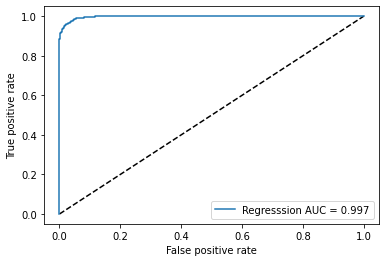

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredr)
auc_keras = auc(fpr_keras, tpr_keras)
print("Regression auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='Regresssion AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


## Visualise patterns in 2-d space

SIG==0 SIG==1


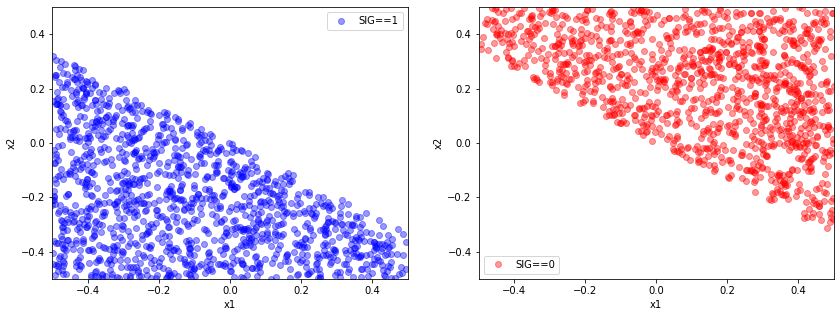

PROB<0.5 PROB>0.5


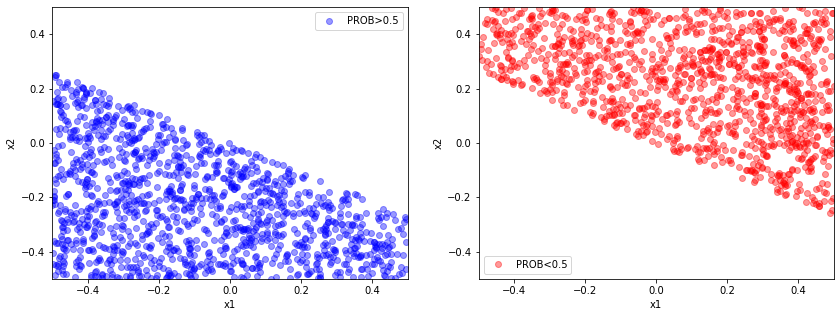

In [58]:
sel1='SIG==0'
sel2='SIG==1'
print(sel1,sel2)
plot_scat(df_test_acc_r, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)
thrmax=0.5
sel1='PROB<'+str(thrmax)
sel2='PROB>'+str(thrmax)
print(sel1,sel2)
plot_scat(df_test_acc_r, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)

## Compare label and prediction in 1-d projections

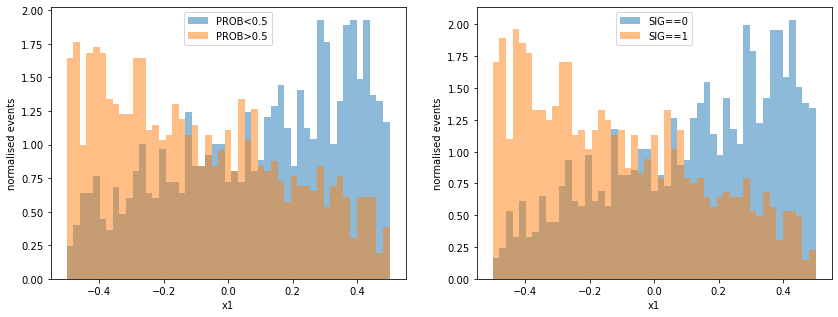

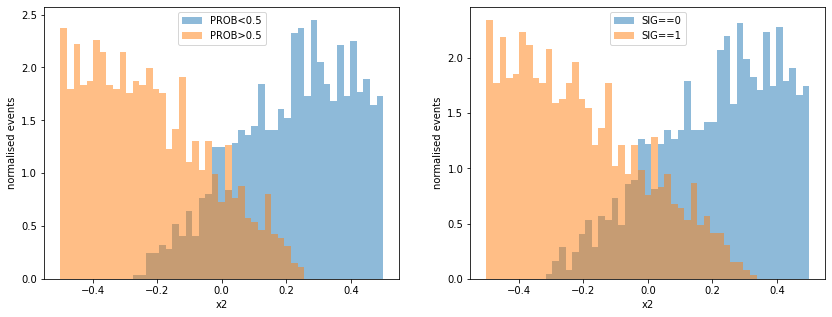

In [59]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
blow=-0.5
bhigh=0.5
bins = np.linspace(blow, bhigh, nbin)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="x1"
plt.hist(df_test_acc_r.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="x2"
plt.hist(df_test_acc_r.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_r.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_r.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_r.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

## Visualise weights

In [60]:
layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]
print('layer weights',layer_weights)
print('layer biases',layer_biases)

layer weights [[-2.1231117]
 [-4.000429 ]]
layer biases [-0.0086646]


# Decision tree classifier

Documentation for the possible options is in <br />

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

test_tree = pd.DataFrame(X_test)
test_tree.columns=col_fin


clf = DecisionTreeClassifier(max_leaf_nodes=6, criterion='gini', splitter='best', random_state=0)
clf.fit(X_train, y_train)

Ypredt=clf.predict_proba(test_tree)

print('Training finished')

Training finished


In [62]:
print(Ypredt.shape)
df_test_acc_t=X_test.copy()
df_test_acc_t['SIG']=y_test
df_test_acc_t['PROB']=Ypredt[:,1]

(2500, 2)


## Plot distribution of output probabilities  for signal and backround

nsig  1296
nbkg  1204


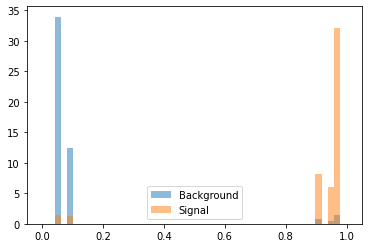

In [63]:
# split according to the label
df_test_acc_t_bkg = df_test_acc_t.query('SIG==0')
df_test_acc_t_sig = df_test_acc_t.query('SIG==1')
print('nsig ',df_test_acc_t_sig.shape[0])
print('nbkg ',df_test_acc_t_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_t_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_t_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC

Regression auc  0.9543019538780197


<function matplotlib.pyplot.show(close=None, block=None)>

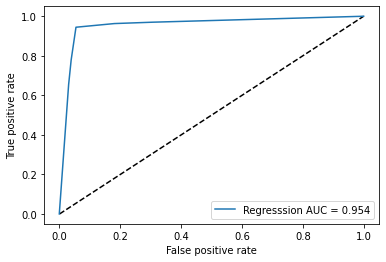

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print("Regression auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='Regresssion AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


## Visualise patterns in 2-d space

SIG==0 SIG==1


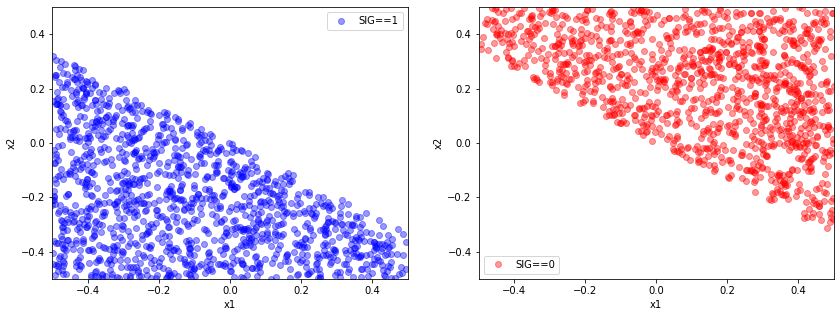

PROB<0.5 PROB>0.5


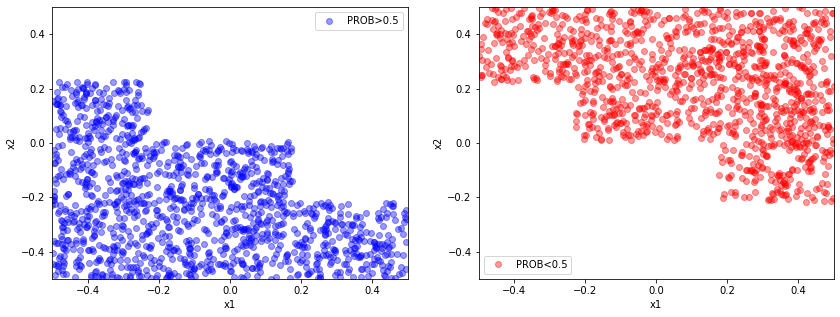

In [65]:
sel1='SIG==0'
sel2='SIG==1'
print(sel1,sel2)
plot_scat(df_test_acc_t, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)
thrmax=0.5
sel1='PROB<'+str(thrmax)
sel2='PROB>'+str(thrmax)
print(sel1,sel2)
plot_scat(df_test_acc_t, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)

## Compare label and prediction in 1-d projections

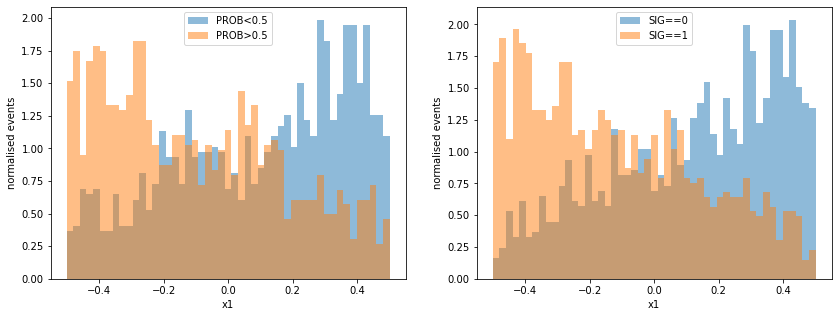

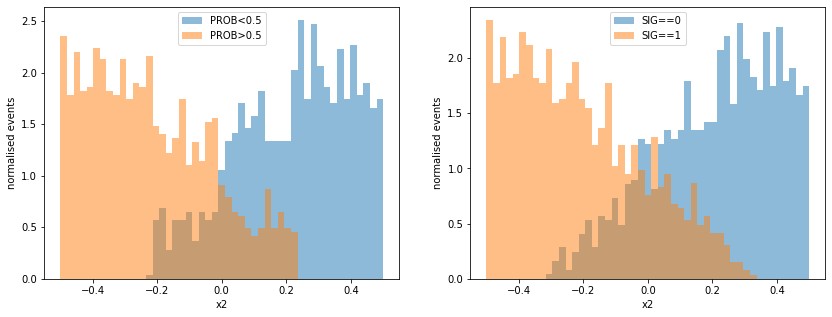

In [66]:
pred_false='PROB<0.5'
pred_true='PROB>0.5'
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
blow=-0.5
bhigh=0.5
bins = np.linspace(blow, bhigh, nbin)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="x1"
plt.hist(df_test_acc_t.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_t.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_t.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_t.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="x2"
plt.hist(df_test_acc_t.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test_acc_t.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test_acc_t.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test_acc_t.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

## Visualize tree

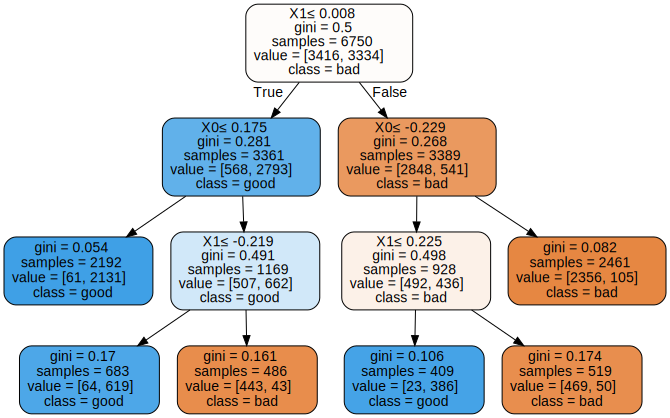

In [67]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
dot_data = tree.export_graphviz(clf, out_file=None,
                     class_names=["bad","good"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Exercises

* Uncomment and try different patterns in generation and look how the algorithms performs in different cases
* Study dependence of performance from number of events
* Study dependence of performance of regression from choice of optimizer number of epoch, size of batches
* Study dependence of performance of decision tree from number of leaves/loss criterion
* Extend generation to three variables, and test the algorithms

# Bonus: Simple man  implementation of search for first splitting

In [68]:
# calculate Gini factor
# 3 inputs: the total number of events, the number of events in each class (good,bad)
def calc_gini(tot, good, bad):
  eg = np.divide(good, tot, out=np.zeros_like(good), where=tot!=0)
  eb = np.divide(bad, tot, out=np.zeros_like(bad), where=tot!=0)
  gini=1-(eg)**2-(eb)**2
  return gini
#
# Algorithm for splitting
#
def get_first_split(X,y,var):
  X_split=X.copy()
  X_split["cc"]=y
# x1 and x2 are between -0.5 and 0.5 scan them in step of 0.01
  nbin=100
  xbin = np.linspace(-0.5, 0.5, nbin)
# create numpy arrays for scan
  tot_p1= np.zeros(nbin)
  good_p1= np.zeros(nbin)
  bad_p1= np.zeros(nbin)
  tot_p2= np.zeros(nbin)
  good_p2= np.zeros(nbin)
  bad_p2= np.zeros(nbin)
  gini_p1=np.zeros(nbin)
  gini_p2=np.zeros(nbin)
#
# loop on values of variable
#
  for i in range(0,len(xbin)):
#  builds the strings for splitting
    sel1=var+'<'+str(xbin[i])
    sel1g=sel1+' & cc==0'
    sel1b=sel1+' & cc==1'
    sel2=var+'>'+str(xbin[i])
    sel2g=sel2+' & cc==0'
    sel2b=sel2+' & cc==1'
# for each value calculate the number of good events (cc=0) and of bad events(cc=1)
    tot_p1[i]=(X_split.query(sel1)).shape[0]
    good_p1[i]=(X_split.query(sel1g)).shape[0]
    bad_p1[i]=(X_split.query(sel1b)).shape[0]
    tot_p2[i]=(X_split.query(sel2)).shape[0]
    good_p2[i]=(X_split.query(sel2g)).shape[0]
    bad_p2[i]=(X_split.query(sel2b)).shape[0]
# calculate the gini for all points on each side of the split
  gini_p1=calc_gini(tot_p1,good_p1,bad_p1)
  gini_p2=calc_gini(tot_p2,good_p2,bad_p2)
# plot Gini for each side of split
  plt.plot(xbin,gini_p1,label=var+'<threshold')
  plt.xlabel(var + ' threshold')
  plt.ylabel('Gini value')
  plt.show()
  plt.plot(xbin,gini_p2)
  plt.xlabel(var + ' threshold')
  plt.ylabel('Gini value')
  plt.show()
# find minimum value of gini for each side
  mgini_p1=np.amin(gini_p1)
  mgini_p2=np.amin(gini_p2)
# find for xhich value of the variable it happens on each side
  cgini_p1=xbin[np.argmin(gini_p1)]
  cgini_p2=xbin[np.argmin(gini_p2)]
  cgini_out=cgini_p1
  mgini_p1_out=mgini_p1
# now choose the side
  mgini_p2_out=gini_p2[np.argmin(gini_p1)]
  isid=1
  if mgini_p2<mgini_p1:
    cgini_out=cgini_p2
    mgini_p1_out=mgini_p2
    mgini_p2_out=gini_p1[np.argmin(gini_p2)]
    isid=2
  return cgini_out,mgini_p1_out,mgini_p2_out,isid

First split


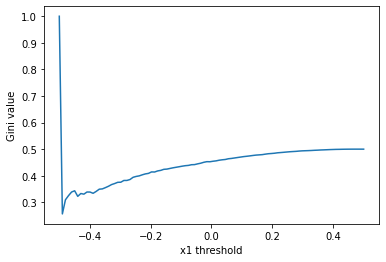

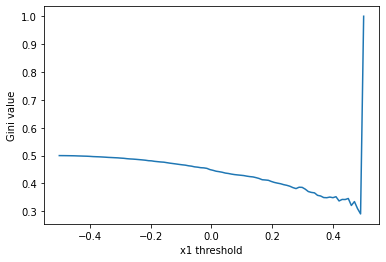

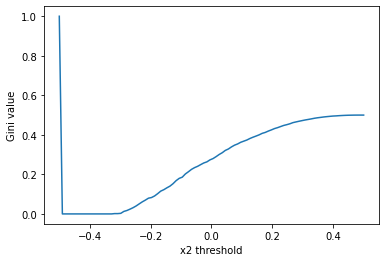

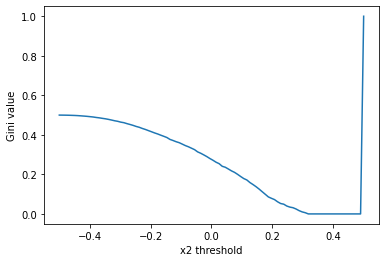

cut x1 -0.4898989898989899  gini left 0.25631897472410103 gini right 0.4998421286476382 side 1
cut x2 -0.4898989898989899  gini left 0.0 gini right 0.4997548564038705 side 1
splitting condition is x2<-0.4898989898989899


In [69]:
# 
print("First split")
cx1,  gp1x1, gp2x1, isidx1= get_first_split(X_train,y_train,'x1')
cx2,  gp1x2, gp2x2, isidx2= get_first_split(X_train,y_train,'x2')
mgm=['<','>']
mgs=mgm[0]
if isidx1==2:
  mgs=mgm[1]
gminx1=min(gp1x1,gp2x1)
gminx2=min(gp1x2,gp2x1)
cutstrl="x1"+mgs+str(cx1)
cutstrr="x1"+mgs+str(cx1)
if gminx2 < gminx1:
  mgs=mgm[0]
  if isidx2==2:
    mgs=mgm[1]
  cutstrl="x2"+mgs+str(cx2)
  cutstrr="x2>"+mgs+str(cx2)
print('cut x1',cx1,' gini left',gp1x1,'gini right', gp2x1, 'side',isidx1)
print('cut x2',cx2,' gini left',gp1x2,'gini right', gp2x2, 'side',isidx2)
print("splitting condition is",cutstrl)
